# Do the feature engineering according to the selection done in the exploratory data analysis and run a linear regression

In [1]:
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.api as sm

import seaborn as sns

import scipy.stats as stats

from matplotlib import pyplot as plt

import numpy as np

In [2]:
df = pd.read_csv('hour.csv', index_col=0)
df.head()
df.casual.describe()

count    17379.000000
mean        35.676218
std         49.305030
min          0.000000
25%          4.000000
50%         17.000000
75%         48.000000
max        367.000000
Name: casual, dtype: float64

In [3]:
df['dteday'] = pd.to_datetime(df['dteday'])
df['dteday'].head()

instant
1   2011-01-01
2   2011-01-01
3   2011-01-01
4   2011-01-01
5   2011-01-01
Name: dteday, dtype: datetime64[ns]

#### Feature Engineering Function:

In [4]:
#weather = {1: 'nice_weather', 2: 'so_so_weather', 3: 'shit_weather'}
#weather_dummies = pd.get_dummies(df['weathersit'])
#weather_dummies = weather_dummies.drop(weather_dummies.columns[0], axis=1)
#weather_dummies.rename(mapper=weather, axis=1, inplace=True)
#x = pd.concat([x, weather_dummies], axis=1)
#x = x.drop('weathersit', axis=1)

#weather_dummies.head()

In [5]:
#df.loc[:, 'atemp2'] = pd.Series(np.array(df['atemp'])**2)
#df.atemp2

In [6]:
def feature_engineer(x):
    x = x[['yr',
           'mnth',
           'hr',
           'holiday',
           'weekday',
           'workingday',
           'weathersit',
           #'temp',
           'atemp',
           'hum', #is highly insignificant
           'windspeed'
           ]]
    
    if 'mnth' in x:
        # create dummies for months; Feb is not significantly different from 0 and is therefore excluded
        months = {2: 'Feb',3: 'March',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sept',10: 'Oct',11: 'Nov',12: 'Dec'}
        mnth_dummies = pd.get_dummies(x['mnth'])
        mnth_dummies = mnth_dummies.drop(mnth_dummies.columns[0:2], axis=1)
        mnth_dummies.rename(mapper=months, axis=1, inplace=True)
        x = pd.concat([x, mnth_dummies], axis=1)
        x = x.drop('mnth', axis=1)
        
    if 'hr' in x:
        # create dummies for hours
        hrs_dummies = pd.get_dummies(x['hr'])
        hrs_dummies = hrs_dummies.drop(hrs_dummies.columns[0], axis=1)
        x = pd.concat([x, hrs_dummies], axis=1)
        x = x.drop('hr', axis=1)
        
    if 'weekday' in x:
        # create dummies for the weekdays; it turns out that only saturdays yields a statistically significant result
        days = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}
        wday_dummies = pd.get_dummies(x['weekday'])
        wday_dummies = wday_dummies.drop(wday_dummies.columns[0], axis=1)
        wday_dummies.rename(mapper=days, axis=1, inplace=True)
        #x = pd.concat([x, pd.DataFrame(wday_dummies['Sat'])], axis=1)
        x = pd.concat([x, wday_dummies], axis=1)
        x = x.drop('weekday', axis=1)
        
    if 'weathersit' in x:
        weather = {1: 'nice_weather', 2: 'so_so_weather', 3: 'shit_weather', 4: 'really shit weather'}
        weather_dummies = pd.get_dummies(x['weathersit'])
        weather_dummies = weather_dummies.drop(weather_dummies.columns[0], axis=1)
        weather_dummies.rename(mapper=weather, axis=1, inplace=True)
        x = pd.concat([x, weather_dummies], axis=1)
        x = x.drop('weathersit', axis=1)
        
    if 'atemp' in x:
        x.loc[:, 'atemp2'] = x['atemp']**2
        x = x.drop('atemp', axis=1)
        
    
    return x

#### Split the data:

In [7]:
# split the data into input and output variables
X = df.drop('cnt', axis=1)
y = df['cnt']
casual = df['casual']
registered = df['registered'] 

# split the data into training and test data for casual
Xtrain, Xtest, ctrain, ctest = train_test_split(X, casual, random_state=42)

# split the data into training and test data for casual
Xtrain, Xtest, rtrain, rtest = train_test_split(X, registered, random_state=42)

# split the data into training and test data for casual
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42)

#### Feature Engineering:

In [8]:
Xtrain = feature_engineer(Xtrain)
Xtest = feature_engineer(Xtest)
Xtrain.head()

,yr,holiday,workingday,hum,windspeed,March,Apr,May,Jun,Jul,...,Mon,Tue,Wed,Thu,Fri,Sat,so_so_weather,shit_weather,really shit weather,atemp2
instant,,,,,,,,,,,,,,,,,,,,,
1946,0,0,0,0.45,0.2537,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0.074365
13427,1,0,1,0.35,0.3582,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0.719952
12899,1,0,1,0.28,0.4627,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0.424452
2571,0,0,1,0.62,0.1940,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0.121452
10765,1,0,1,0.39,0.3582,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.250000


In [9]:
#corr = Xtrain.corr()
#corr

#### Fit the model:

In [10]:
mc = LinearRegression()
mr = LinearRegression()

In [11]:
mc.fit(Xtrain, ctrain)
mc.coef_, mc.intercept_

(array([ 1.24413066e+01, -2.83652544e+13, -2.83652544e+13, -2.45934740e+01,
        -1.52580657e+01,  1.50678997e+01,  2.06206602e+01,  2.18152326e+01,
         1.02743113e+01,  1.82227518e+00,  9.09274066e+00,  1.69956480e+01,
         2.04565012e+01,  1.16928407e+01,  4.06103019e+00, -2.00297626e+00,
        -2.84867027e+00, -5.78578830e+00, -6.41786671e+00, -3.46402760e+00,
        -1.25636518e+00,  5.31941567e+00,  1.39402860e+01,  2.02451248e+01,
         3.31760749e+01,  4.35729171e+01,  5.14966677e+01,  5.32568588e+01,
         5.14674925e+01,  5.12216026e+01,  5.25966505e+01,  5.55482965e+01,
         4.22290796e+01,  3.18411217e+01,  2.22878754e+01,  1.53104515e+01,
         1.06888607e+01,  4.72621204e+00,  2.83652544e+13,  2.83652544e+13,
         2.83652544e+13,  2.83652544e+13,  2.83652544e+13,  5.88919784e+00,
        -3.95847153e+00, -1.10518271e+01, -9.36972039e+00,  9.66835623e+01]),
 12.843588613194335)

In [12]:
mr.fit(Xtrain, rtrain)
mr.coef_, mr.intercept_

(array([ 7.49415898e+01,  2.83138810e+13,  2.83138810e+13, -5.01386942e+01,
        -2.15974891e+01,  2.04394439e+01,  3.85498827e+01,  4.88971110e+01,
         4.63945650e+01,  2.83682312e+01,  4.37331511e+01,  7.41330340e+01,
         7.62546590e+01,  5.35028471e+01,  3.67574466e+01, -1.46954318e+01,
        -2.55856644e+01, -3.28087222e+01, -3.45417267e+01, -1.95250304e+01,
         3.43817324e+01,  1.64518721e+02,  2.98175465e+02,  1.43308432e+02,
         7.85436008e+01,  9.14400304e+01,  1.27169910e+02,  1.20892272e+02,
         9.96519614e+01,  1.09592027e+02,  1.75985038e+02,  3.30311834e+02,
         2.98892224e+02,  2.07160051e+02,  1.39506274e+02,  9.44697567e+01,
         6.15341087e+01,  2.84159057e+01, -2.83138810e+13, -2.83138810e+13,
        -2.83138810e+13, -2.83138810e+13, -2.83138810e+13,  8.73146220e+00,
        -6.60718163e+00, -5.29932221e+01, -1.26620958e+02,  1.41733285e+02]),
 -51.82822389999234)

#### Evaluate the model:

In [13]:
# let's have a look at the R2 of the model
round(mc.score(Xtrain, ctrain), 2)

0.59

In [14]:
# let's have a lookt at the R2 of the model using the test data
round(mc.score(Xtest, ctest), 2)

0.59

In [15]:
round(mr.score(Xtrain, rtrain), 2)

0.68

In [16]:
round(mr.score(Xtest, rtest), 2)

0.67

#### Use statsmodels to output some statistics on the regression results

In [17]:
# Fit and summarize OLS model
modc = sm.OLS(ctrain, sm.add_constant(Xtrain))

res = modc.fit()

res.summary()

/Users/stefanroth/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 casual   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     395.6
Date:                Wed, 12 Jun 2019   Prob (F-statistic):               0.00
Time:                        19:49:53   Log-Likelihood:                -63547.
No. Observations:               13034   AIC:                         1.272e+05
Df Residuals:                   12986   BIC:                         1.275e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.8012      2.209      5.796      0.000       8.472      17.130
yr                     12.4374      0.561     22.155      0.000      11.337      13.538
holiday                -5.4480      1.576     -3.456      0.001      -8.538      -2.358
workingday            -25.7391      0.648    -39.692      0.000     -27.010     -24.468
hum                   -24.5986      2.002    -12.286      0.000     -28.523     -20.674
windspeed             -15.2613      2.462     -6.199      0.000     -20.087     -10.436
March                  15.0764      1.222     12.339      0.000      12.682      17.471
Apr                    20.6134      1.305     15.798      0.000      18.056      23.171
May                    21.8120      1.505     14.496      0.000      18.863      24.761
Jun                    10.2789      1.713      6.000      0.000       6.921      13.637
Jul                     1.8275      1.938      0.943      0.346      -1.972       5.627
Aug                     9.0875      1.744      5.212      0.000       5.670      12.505
Sept                   17.0163      1.558     10.921      0.000      13.962      20.070
Oct                    20.4538      1.328     15.406      0.000      17.851      23.056
Nov                    11.6858      1.221      9.570      0.000       9.292      14.079
Dec                     4.0644      1.200      3.388      0.001       1.713       6.416
1                      -2.0488      1.930     -1.062      0.288      -5.832       1.734
2                      -2.8406      1.926     -1.475      0.140      -6.616       0.934
3                      -5.7814      1.980     -2.920      0.004      -9.662      -1.900
4                      -6.4279      1.944     -3.306      0.001     -10.239      -2.617
5                      -3.4585      1.939     -1.783      0.075      -7.260       0.343
6                      -1.2592      1.946     -0.647      0.518      -5.074       2.556
7                       5.3165      1.948      2.729      0.006       1.498       9.135
8                      13.9419      1.936      7.201      0.000      10.147      17.737
9                      20.2435      1.946     10.403      0.000      16.429      24.058
10                     33.1729      1.949     17.025      0.000      29.354      36.992
11                     43.5665      1.972     22.091      0.000      39.701      47.432
12                     51.4933      1.962     26.239      0.000      47.647      55.340
13                     53.2545      1.976     26.948      0.000      49.381      57.128
14                     51.4641      2.018     25.498      0.000      47.508      55.420
15                     51.2162      2.006     25.527      0.000      47.283      55.149
16                     52.5900      1.990     26.432      0.000      48.690      56.490
17 

In [18]:
# Fit and summarize OLS model
modr = sm.OLS(rtrain, sm.add_constant(Xtrain))

res = modr.fit()

res.summary()

/Users/stefanroth/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             registered   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     577.2
Date:                Wed, 12 Jun 2019   Prob (F-statistic):               0.00
Time:                        19:49:53   Log-Likelihood:                -76610.
No. Observations:               13034   AIC:                         1.533e+05
Df Residuals:                   12986   BIC:                         1.537e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -51.7896      6.017     -8.607      0.000     -63.584     -39.995
yr                     74.9455      1.529     49.001      0.000      71.948      77.943
holiday               -14.5898      4.294     -3.397      0.001     -23.007      -6.172
workingday             39.0026      1.767     22.076      0.000      35.540      42.466
hum                   -50.1297      5.455     -9.190      0.000     -60.822     -39.438
windspeed             -21.5956      6.707     -3.220      0.001     -34.743      -8.449
March                  20.4314      3.329      6.138      0.000      13.907      26.956
Apr                    38.5570      3.555     10.846      0.000      31.589      45.525
May                    48.8950      4.099     11.928      0.000      40.860      56.930
Jun                    46.3875      4.667      9.939      0.000      37.239      55.536
Jul                    28.3646      5.281      5.371      0.000      18.013      38.716
Aug                    43.7370      4.750      9.207      0.000      34.426      53.048
Sept                   74.1168      4.245     17.459      0.000      65.796      82.438
Oct                    76.2523      3.617     21.081      0.000      69.162      83.342
Nov                    53.5079      3.327     16.084      0.000      46.987      60.029
Dec                    36.7604      3.268     11.248      0.000      30.354      43.166
1                     -14.6451      5.258     -2.785      0.005     -24.951      -4.339
2                     -25.5964      5.247     -4.878      0.000     -35.881     -15.312
3                     -32.8153      5.394     -6.083      0.000     -43.389     -22.242
4                     -34.5337      5.297     -6.519      0.000     -44.917     -24.150
5                     -19.5327      5.284     -3.697      0.000     -29.890      -9.175
6                      34.3832      5.302      6.485      0.000      23.990      44.776
7                     164.5222      5.308     30.997      0.000     154.118     174.926
8                     298.1740      5.275     56.526      0.000     287.834     308.514
9                     143.3103      5.301     27.032      0.000     132.919     153.702
10                     78.5492      5.309     14.797      0.000      68.144      88.955
11                     91.4477      5.373     17.020      0.000      80.916     101.979
12                    127.1724      5.347     23.786      0.000     116.692     137.653
13                    120.8945      5.384     22.454      0.000     110.341     131.448
14                     99.6525      5.499     18.122      0.000      88.874     110.431
15                    109.5894      5.466     20.049      0.000      98.875     120.304
16                    175.9899      5.421     32.467      0.000     165.365     186.615
17 

#### Check that the assumptions of the model hold:

In [19]:
errors = mc.predict(Xtrain) + mr.predict(Xtrain) - ytrain
round(errors.sum(), 2)

-14.45

* the sum of errors is roughly zero; the assumption of zero error in expectation holds

In [20]:
stats.shapiro(errors)

/Users/stefanroth/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9732308983802795, 1.2751816025355835e-43)

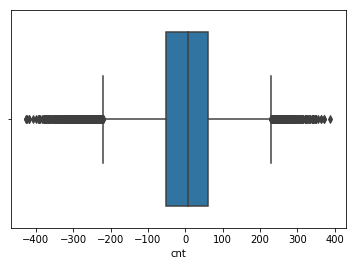

In [21]:
sns.boxplot(errors)

* I think that we can more or less accept the normality of the errors, although the shapiro test strongly leeds us to reject the Null
* Maybe we have to throw out some outliers or actually do some feature engineering

#### Plot a Q-Q plot to "test" for homoskedasticity

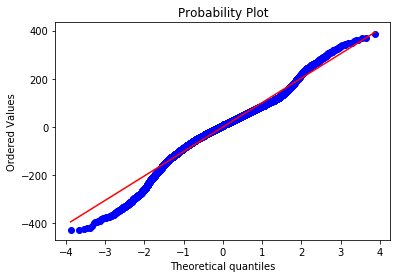

In [22]:
stats.probplot(errors, dist="norm", plot=plt)
plt.show()

(array([  54.,  217.,  395., 1081., 3199., 4900., 2456.,  461.,  225.,
          46.]),
 array([-426.74558639, -345.27452407, -263.80346174, -182.33239942,
        -100.8613371 ,  -19.39027477,   62.08078755,  143.55184987,
         225.0229122 ,  306.49397452,  387.96503684]),
 <a list of 10 Patch objects>)

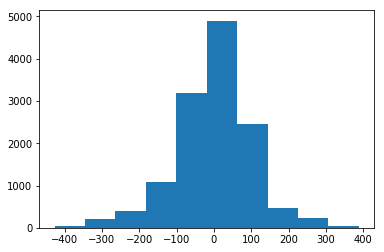

In [23]:
plt.hist(errors)

The errors seem to be quite normal and almost evenly distributed over the whole space except for the fat right tail. What is the cause for these observations?

# Inspect the outliers!!!